<a href="https://colab.research.google.com/github/QuangMinhPhan23/emotions-classification-for-tweets/blob/main/report_all_in_one.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# AnotherGroup

# Introduction & Motivation

Emotion classification is a subfield of natural language processing (NLP) that involves identifying the emotional tone behind a body of text. In this project, we focus on classifying English tweets into one of six basic emotions:
`sadness`, `joy`, `love`, `anger`, `fear`, or `surprise`.

Emotion analysis is an important task for applications such as:
- Sentiment monitoring on social media
- Enhancing conversational agents
- Understanding human emotional states in text

This project leverages transfer learning to achieve good performance on this task with limited computational resources. This project is run on Google Colab, parameters are adjusted to fit the memory of Google Colab.  We compare the performance of traditional recurrent neural networks (RNN, LSTM, GRU) with modern transformer-based architectures (DistilBERT, ELECTRA) on the DAIR AI Emotion dataset.

In [ ]:
!pip install -U datasets huggingface_hub fsspec

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 558.8/558.8 kB 15.1 MB/s eta 0:00:00
  Attempting uninstall: huggingface_hub
    Found existing installation: huggingface-hub 0.34.1
    Uninstalling huggingface-hub-0.34.1:
      Successfully uninstalled huggingface-hub-0.34.1


In [ ]:
!pip install tensorflow


# Dataset

We use the **[`dair‑ai/emotion`](https://huggingface.co/datasets/dair-ai/emotion)** dataset hosted on HuggingFace.  
Key properties of the dataset:
- Source: HuggingFace Datasets
- Size: ~20,000 English text samples
- Splits: `train`, `validation`, and `test`
- Each example: a short sentence and its annotated emotion label
- Task: supervised multi‑class classification (6 classes)

In [ ]:
# Load dataset
from datasets import load_dataset
dataset = load_dataset("dair-ai/emotion", "split")

Examples of the dataset is shown below.

In [ ]:
# Show the keys
print(dataset.keys())

# Show 5 examples from the training split
for i in range(5):
    print(dataset['train'][i])

dict_keys(['train', 'validation', 'test'])
{'text': 'i didnt feel humiliated', 'label': 0}
{'text': 'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake', 'label': 0}
{'text': 'im grabbing a minute to post i feel greedy wrong', 'label': 3}
{'text': 'i am ever feeling nostalgic about the fireplace i will know that it is still on the property', 'label': 2}
{'text': 'i am feeling grouchy', 'label': 3}


# Exploratory Analysis of Data

## Properties and Challenges
The dataset has the following characteristics:
- **Number of classes:** 6
  - `sadness`, `joy`, `love`, `anger`, `fear`, `surprise`
- **Size:**
  - Training: ~16,000 examples
  - Validation: ~2,000 examples
  - Test: ~2,000 examples

There are sentences that has special characters that can be removed during preprocessing like 'http', 'href' or 'url'.

In [ ]:
count = 0
for example in dataset['train']:
    text = example['text']
    if 'href' in text or 'http' in text or 'url' in text:
        print(text)
        count += 1
    if count >= 5:
        break

i feel they are pretty safe on my blog img src http s
i stopped feeling so exhausted a href http provokingbeauty
i feel so dazed a href http twitter
i feel unwelcome at work sometimes and think people might be talking about me rel bookmark i feel unwelcome at work sometimes and think people might be talking about me april a class url fn n href http www
i feel like it looks gorgeous with curls so instead of making the full transition i ended up getting extremely natural red lowlights on the bottom section of my hair


Sentences in the dataset are relatively short, with most being around *(5-20 words)*, with the highest being 18 words. We can limit the MAX_LEN = 50 for easier processing.

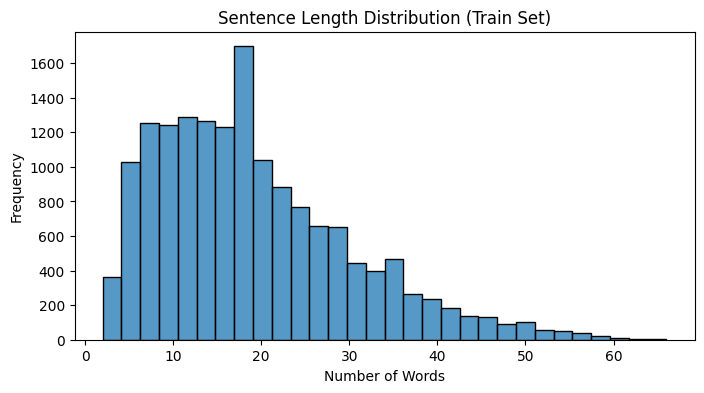

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
df_train = dataset['train'].to_pandas()
df_train['text_length'] = df_train['text'].apply(lambda x: len(x.split()))

plt.figure(figsize=(8,4))
sns.histplot(df_train['text_length'], bins=30, kde=False)
plt.title('Sentence Length Distribution (Train Set)')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.show()

Each example is a short sentence (`text`) paired with a label (`label`) corresponding to one of the emotions above.

The distribution of classes is imbalanced. However, the imbalance is not too high. We choose not to fix this imbalance.  
From the figures, we observe:
- Majority classes: joy, sadness
- Minority classes: anger, fear, love, surprise

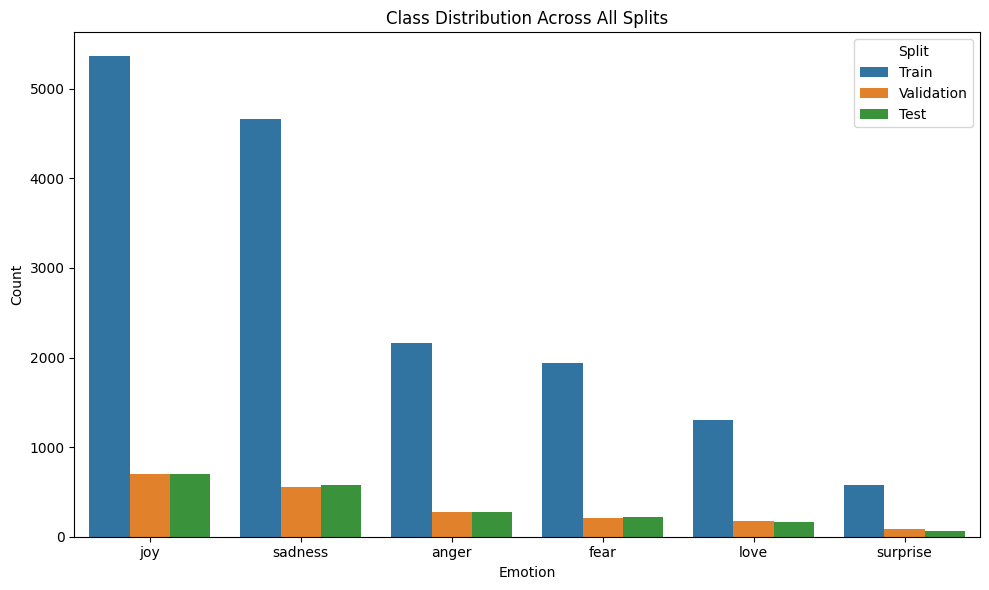

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Combine datasets into one DataFrame
def merge_splits_for_plotting(dataset):
    all_data = []
    for split_name in ['train', 'validation', 'test']:
        df = pd.DataFrame(dataset[split_name])
        df['split'] = split_name.capitalize()
        df['label_name'] = df['label'].map(
            lambda x: dataset['train'].features['label'].int2str(x)
        )
        all_data.append(df)
    return pd.concat(all_data)

# Plot
def plot_merged_class_distribution(dataset):
    combined_df = merge_splits_for_plotting(dataset)
    plt.figure(figsize=(10, 6))
    sns.countplot(data=combined_df, x='label_name', hue='split',
                  order=combined_df['label_name'].value_counts().index)
    plt.title('Class Distribution Across All Splits')
    plt.xlabel('Emotion')
    plt.ylabel('Count')
    plt.legend(title='Split')
    plt.tight_layout()
    plt.show()

# Call the function
plot_merged_class_distribution(dataset)

## Preprocessing

Before feeding tweets into our models, we applied several preprocessing steps to clean, normalize, and tokenize the raw text. These steps were crucial for handling the noisy, informal, and short nature of tweets.

### Text Cleaning

We applied basic normalization to clean the raw tweet text:

| Step               | Description                           |
|--------------------|---------------------------------------|
| Remove URLs         | Regex: `http\S+`, `www\S+`, `href`     |
| Remove mentions     | Regex: `@\w+`, `#\w+`                  |
| Remove HTML tags    | e.g., `a href` fragments               |
| Lowercasing         | Standard text normalization            |
| Remove punctuation  | Using regex                            |

We also add stop words to exclude the words are not english.

In [ ]:
import re
import nltk
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

def clean_text(example):

    # Clean text
    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()
    text = example['text']
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    text = re.sub(r'\@\w+|\#', '', text)
    text = re.sub(r'\W', ' ', text)
    text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    text = text.lower()
    text = ' '.join([lemmatizer.lemmatize(word) for word in text.split() if word not in stop_words])
    return {'cleaned_text': text}

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


### Tokenization Strategy

In this project, we experimented with 4 different tokenization strategies depending on the model type and input pipeline.

| Model              | Tokenizer Used            
|--------------------|---------------------------
| RNN                | Keras Tokenizer
| LSTM               | Keras Tokenizer  
| GRU                | Keras Tokenizer
| DistilBERT         | `distilbert-base-uncased` tokenizer
| ELECTRA            | `electra-base-discriminator` tokenizer

The tokenization part will be shown in the code of each model.
All sequences were padded or truncated to a fixed length of **50 tokens** to ensure consistent input shape across models.

#### Keras Tokenizer (Word-Level)

- Comes from `tensorflow.keras.preprocessing.text.Tokenizer`
- Splits text into **space-separated whole words**  
  e.g., `"I'm happy"` → `["i'm", "happy"]`
- Converts words to integer IDs based on frequency
- Out-of-vocabulary (OOV) words can be handled via a special token
- Used in: **RNN**, **LSTM**, **GRU** (baseline models)

Pros:

- Simple and fast
- Works well with pretrained word embeddings like GloVe
- Easy to visualize and debug

Cons:

- Cannot break down unseen words (e.g., “unlovable” is fully OOV)
- No context-awareness

#### `distilbert-base-uncased` tokenizer and `electra-base-discriminator` tokenizer (Subword-Level, WordPiece)
Provided by Hugging Face Transformers

- Uses WordPiece subword tokenization
- Lowercases text automatically (for uncased models)
- Splits rare words into known subword units e.g., "unhappiness" → ["un", "##happiness"]

Pros:

- Handles OOV words more gracefully via subword splitting
- More robust to misspellings and rare terms

Cons: Slower than Keras for basic preprocessing

# Methods

## Embedding Strategy

| Model     | Tokenizer         | Embedding Type      |
|-----------|-------------------|---------------------|
| RNN       | Keras (word-level)| Random              |
| LSTM      | Keras             | GloVe / Random      |
| GRU       | Keras             | GloVe / Random      |
| DistilBERT| HF WordPiece      | Pretrained (contextual) |
| ELECTRA   | HF WordPiece      | Pretrained (contextual) |

We applied Random embedding (learned from scratch during training) for all recurrent models. In the Transformer-based Models (DistilBERT, ELECTRA), Embeddings are already part of the pretrained model.

**GloVe Embedding**

To improve semantic understanding in our recurrent models (LSTM and GRU), we incorporated **pre-trained GloVe word embeddings**.

GloVe (Global Vectors for Word Representation) is a widely used set of word embeddings trained on massive corpora like Wikipedia and Gigaword. It captures semantic relationships between words based on their global co-occurrence statistics.

For example:
- `vector("king") - vector("man") + vector("woman") ≈ vector("queen")`

We used the **300-dimensional version of `glove.6B.300d.txt`** from [GloVe 6B 300d KaggleHub](https://www.kaggle.com/datasets/thanakomsn/glove6b300dtxt). Then, we built an embedding matrix that maps our tokenizer's vocabulary to their corresponding GloVe vectors.

- If a token exists in GloVe, we used the pretrained vector.
- If not, we initialized it randomly (OOV handling).
- The resulting matrix was converted into a `torch.nn.Embedding` layer.
- We set `freeze=False` to allow fine-tuning during training.

This setup allowed our **LSTM and GRU** models to benefit from rich semantic information learned from large corpora.






In [ ]:
!pip install kagglehub

In [ ]:
# GloVe Setup

import numpy as np
import kagglehub
import torch
from tensorflow.keras.preprocessing.text import Tokenizer # Import the Tokenizer

# Download GloVe using KaggleHub
path = kagglehub.dataset_download("thanakomsn/glove6b300dtxt")

# Construct the full path to the actual GloVe file
glove_file = f"{path}/glove.6B.300d.txt"
embedding_dim = 300

def load_glove_embeddings(glove_path):
    glove_dict = {}
    with open(glove_path, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.strip().split()
            word = values[0]
            vector = np.array(values[1:], dtype=np.float32)
            glove_dict[word] = vector
    return glove_dict

glove = load_glove_embeddings(glove_file)

# Initialize the tokenizer before using it
tokenizer = Tokenizer()
# Fit the tokenizer on the training data to build the vocabulary
# Assuming 'dataset' and 'cleaned_text' are available from previous cells
if 'dataset' in locals() and 'train' in dataset and 'cleaned_text' in dataset['train'].features:
    tokenizer.fit_on_texts(dataset['train']['cleaned_text'])
else:
    print("Warning: 'dataset' with 'train' split and 'cleaned_text' feature not found. "
          "GloVe embedding matrix will be based on an empty vocabulary.")


# Convert tokenizer vocab to embedding matrix
vocab = tokenizer.word_index  # Use word_index for Keras Tokenizer vocab
vocab_size = len(vocab) + 1 # Add 1 for the unknown token
embedding_matrix = np.random.normal(scale=0.6, size=(vocab_size, embedding_dim)).astype(np.float32)

# Assign GloVe vectors to words in the vocabulary
for word, idx in vocab.items():
    if word in glove:
        embedding_matrix[idx] = glove[word]

# Convert to torch tensor
embedding_tensor = torch.tensor(embedding_matrix)

# Create embedding layer
# Use padding_idx for the padding token if necessary (usually index 0)
glove_embedding = torch.nn.Embedding.from_pretrained(embedding_tensor, freeze=False, padding_idx=0)

100%|██████████| 386M/386M [00:06<00:00, 62.6MB/s]

Extracting files...


## Evaluation Metrics

To evaluate model performance on the test set, we use the following metrics:

- **Classification Report**: Includes precision, recall, and F1-score for each emotion class.
- **Macro-Averaged Metrics**: Precision, recall, and F1 are averaged across all classes equally, regardless of class frequency. This ensures that minority classes like `surprise` and `love` are fairly represented.
- **Confusion Matrix**: Visualizes correct and incorrect predictions for each class, helping identify common misclassifications (e.g., `love` often confused with `joy`).

These metrics allow for a comprehensive understanding of model behavior across both frequent and rare emotion categories.

We also print out the total trainable parameters for easier comparison.
Training and validation loss are plotted across epochs to monitor learning progress and detect overfitting.

In [ ]:
!pip install seaborn

In [ ]:
import pandas as pd
import seaborn as sns

# Count total trainable parameters
def count_parameters(model):
    total = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"\nTotal Trainable Parameters: {total:,}\n")

# Evaluation: classification report, confusion matrix, and loss plots
def evaluate_and_plot_metrics(model_name, model, loader, label_names):
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for batch in loader:
            inputs, labels = batch
            input_ids = inputs['input_ids']
            outputs = model(input_ids)
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.tolist())
            all_labels.extend(labels.tolist())

    # Print classification report
    from sklearn.metrics import classification_report, confusion_matrix
    print(f"\nClassification Report for {model_name}:\n")
    print(classification_report(all_labels, all_preds, target_names=label_names, digits=4))

    # Get macro-averaged metrics
    report = classification_report(all_labels, all_preds, target_names=label_names, digits=4, output_dict=True)
    macro_avg = report['macro avg']
    accuracy = report['accuracy']
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Macro Avg Precision: {macro_avg['precision']:.4f} | Recall: {macro_avg['recall']:.4f} | F1: {macro_avg['f1-score']:.4f}")

    # Plot confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_names, yticklabels=label_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.show()

import matplotlib.pyplot as plt

def plot_loss_curves(model_name, train_losses, val_losses):
    """
    Plots training and validation loss over epochs.

    Parameters:
    - model_name (str): Name of the model for the plot title
    - train_losses (list): Training loss values per epoch
    - val_losses (list): Validation loss values per epoch
    """
    plt.figure(figsize=(8, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'{model_name} - Training vs Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


# Models


## Recurrent-based Models
- **Training Phase**:
  - The model is set to training mode with `model.train()`, which enables dropout and gradient tracking.
  - For each batch:
    - Input tensors are passed through the model.
    - Cross-entropy loss is computed against the ground-truth labels.
    - Backpropagation is performed using `loss.backward()`.
    - Optimizer updates the model weights using `optimizer.step()`.

- **Validation Phase**:
  - The model is switched to evaluation mode with `model.eval()` to disable dropout.
  - No gradients are computed during validation (`torch.no_grad()`).
  - The model is evaluated on the validation set, and average validation loss is recorded.

In [ ]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=5, model_name="Model"):
    train_losses = []
    val_losses = []

    for epoch in range(1, num_epochs + 1):
        # Training phase
        model.train()
        running_loss = 0.0
        for batch in train_loader:
            inputs, labels = batch
            input_ids = inputs['input_ids']

            optimizer.zero_grad()
            outputs = model(input_ids)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        avg_train_loss = running_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Validation phase
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for batch in val_loader:
                inputs, labels = batch
                input_ids = inputs['input_ids']
                outputs = model(input_ids)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

        avg_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        print(f"{model_name} | Epoch {epoch} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")

    return train_losses, val_losses


### RNN

To establish a baseline for comparison, we implemented a **basic Recurrent Neural Network (RNN)** for emotion classification. Although RNNs have been largely surpassed by more advanced architectures like LSTM, GRU, and Transformers, they remain a valuable starting point for understanding sequence modeling.

#### Key Reasons for Choosing RNN

1. **Sequential Modeling of Text**  
   RNNs process input tokens one at a time while maintaining a hidden state that captures prior context. This makes them well-suited for tasks like emotion classification, where the **order of words** matters.

2. **Interpretability and Simplicity**  
   Compared to LSTM and GRU, RNNs have fewer parameters and a simpler structure. This allows for:
   - Faster prototyping
   - Easier debugging
   - A clearer understanding of model behavior before introducing complexity

3. **Bidirectionality Improves Context**  
   We used a **bidirectional RNN**, which processes text both left-to-right and right-to-left. This allows the model to capture context from both past and future words in the sentence — which is crucial in short, informal tweets where emotional meaning is subtle.

#### Design Notes

- Tokenization: Word-level using Keras tokenizer  
- **Embedding Layer**: Randomly initialized, dimension = 128
- **RNN Layer**:
  - Type: `torch.nn.RNN`
  - Layers: 2
  - Bidirectional: True
  - Hidden size: 256
  - Dropout: 0.3 (between RNN layers)
- **Output Layer**: Fully connected (`Linear`) layer projecting concatenated hidden states to 6 emotion classes

Training Configuration

- **Batch Size**: 32
- **Loss Function**: CrossEntropyLoss
- **Optimizer**: Adam
- **Learning Rate**: 1e-3
- **Epochs**: 5


#### Limitations

- **Vanishing gradients** on long sequences
- **No memory gates**, so it struggles to model long-term dependencies

> Overall, RNN serves as a meaningful and educational baseline to show how each subsequent model improves on this foundational approach.

### LSTM

To address the limitations of the basic RNN baseline, we implemented a **Long Short-Term Memory (LSTM)** network for emotion classification. LSTMs are designed to overcome the vanishing gradient problem and better capture long-term dependencies in sequence data.

#### Key Reasons for Choosing LSTM

1. **Handles Long-Term Dependencies**  
   LSTMs introduce memory cells and gating mechanisms (input, forget, and output gates) that help retain relevant information across longer sequences, which is essential for detecting emotional cues spread across a sentence.

2. **Improved Gradient Flow**  
   The gating structure allows for better backpropagation through time, avoiding the vanishing gradient issues seen in basic RNNs.

3. **Bidirectional Context**  
   Like our RNN, we use a **bidirectional LSTM** to capture both past and future context in tweets. This is especially useful in short texts where sentiment cues can appear anywhere in the sequence.

#### Design Notes

- Tokenization: Word-level using Keras tokenizer
- **Embedding Layer**: Randomly initialized, dimension = 128 / GloVe
- **LSTM Layer**:
  - Type: `torch.nn.LSTM`
  - Layers: 2
  - Bidirectional: True
  - Hidden size: 256
  - Dropout: 0.3 (between LSTM layers)
- **Output Layer**: Fully connected (`Linear`) layer projecting concatenated hidden states to 6 emotion classes

#### Training Configuration

- **Batch Size**: 32  
- **Loss Function**: CrossEntropyLoss  
- **Optimizer**: Adam  
- **Learning Rate**: 1e-3  
- **Epochs**: 5

#### Limitations

- **Higher computational cost** than basic RNNs  
- **More parameters**, which increases risk of overfitting on small datasets

> Overall, the LSTM provides a strong improvement over RNN by capturing more complex emotional dependencies in text, especially for subtle or long-distance emotional signals.


### GRU

To test a lightweight alternative to LSTM, we implemented a **Gated Recurrent Unit (GRU)** network for emotion classification. GRUs offer a simplified architecture with fewer parameters while maintaining competitive performance.

#### Key Reasons for Choosing GRU

1. **Faster and Simpler Than LSTM**  
   GRUs combine the forget and input gates into a single **update gate**, reducing model complexity. This allows for faster training and fewer parameters, making GRUs attractive for resource-constrained environments.

2. **Good Performance on Short Sequences**  
   Emotion classification from tweets involves short, informal text. GRUs are well-suited for such sequences and often match LSTM performance on text classification benchmarks.

#### Design Notes

- Tokenization: Word-level using Keras tokenizer
- **Embedding Layer**: Pretrained GloVe vectors (300-dimensional)/ Random Embedding  
- **GRU Layer**:
  - Type: `torch.nn.GRU`
  - Layers: 1
  - Hidden size: 256
- **Output Layer**: Fully connected (`Linear`) layer projecting GRU hidden state to 6 emotion classes

#### Training Configuration

- **Batch Size**: 32  
- **Loss Function**: CrossEntropyLoss  
- **Optimizer**: Adam  
- **Learning Rate**: 1e-3  
- **Epochs**: 5

#### Limitations

- **No bidirectionality** in current config — future improvements could add this
- Slightly less expressive than LSTM on long or complex sequences

> GRU provides a strong trade-off between performance and computational cost, especially when combined with pre-trained embeddings. It delivers fast training and effective classification while using fewer parameters than LSTM.


## Transformer-based Models
Transformers rely heavily on self-attention mechanisms to capture contextual relationships between tokens in a sequence. The training loop implemented in the train_transformer_model function is designed to fine-tune a pre-trained Transformer architecture, typically from the Hugging Face Transformers library, which inherently includes multi-head self-attention layers.

The core of the Transformer model is its self-attention mechanism, which allows each token to dynamically focus on other relevant tokens in the input sequence. This mechanism is particularly useful in natural language understanding tasks where word meaning is context-dependent.

- Input Encoding: Each input batch contains tokenized text passed to the model as input_ids along with an attention_mask. The attention mask tells the model which tokens are actual input (value 1) and which are padding (value 0), ensuring attention weights are not wasted on irrelevant positions.

- Self-Attention Computation: Inside the model, self-attention layers compute attention scores between each token and all others in the sequence. These scores are used to generate contextualized token representations, which are essential for downstream classification or generation tasks.

- Backpropagation Through Attention: During training, the attention weights and output representations are differentiable. Gradients flow not only through the feed-forward layers but also through the attention mechanism itself. This allows the model to learn which parts of the input are most important for the task.

- Multi-head Attention: The model typically employs multi-head attention, where multiple attention operations are run in parallel. Each head learns to capture different types of relationships, and their outputs are concatenated and linearly transformed.

In each training iteration, the model processes the input using attention, producing logits that are compared to true labels using a loss function (e.g., cross-entropy). The outputs.logits are derived after the attention and transformer layers, representing the final decision space. Errors are then backpropagated through the attention layers, allowing the model to refine how attention is distributed across the input.

In [ ]:
def train_transformer_model(model, train_loader, val_loader, optimizer, criterion, num_epochs, device):
    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        model.train()
        total_train_loss = 0
        for batch in train_loader:
            inputs, labels = batch
            input_ids = inputs['input_ids'].to(device)
            attention_mask = inputs['attention_mask'].to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            loss = criterion(outputs.logits, labels)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()

        train_losses.append(total_train_loss / len(train_loader))

        # Validation
        model.eval()
        total_val_loss = 0
        with torch.no_grad():
            for batch in val_loader:
                inputs, labels = batch
                input_ids = inputs['input_ids'].to(device)
                attention_mask = inputs['attention_mask'].to(device)
                labels = labels.to(device)

                outputs = model(input_ids=input_ids, attention_mask=attention_mask)
                loss = criterion(outputs.logits, labels)
                total_val_loss += loss.item()

        val_losses.append(total_val_loss / len(val_loader))
        print(f"Epoch {epoch+1} | Train Loss: {train_losses[-1]:.4f} | Val Loss: {val_losses[-1]:.4f}")

    return train_losses, val_losses



### DistilBERT

To leverage the advantages of pretrained Transformer models, we fine-tuned **DistilBERT** for emotion classification. DistilBERT is a smaller and faster variant of BERT, trained using knowledge distillation, while retaining ~97% of BERT’s performance on language understanding benchmarks.

#### Key Reasons for Choosing DistilBERT

1. **Contextual Understanding**  
   Unlike RNNs or GRUs, DistilBERT uses the self-attention mechanism to learn rich contextual relationships between all tokens in a sentence, regardless of position.

2. **Efficiency**  
   DistilBERT is 40% smaller than BERT and 60% faster during inference, making it ideal for fast experimentation and potential deployment on limited-resource environments.

3. **Pretrained Knowledge**  
   By fine-tuning on our emotion dataset, the model adapts the general language understanding it learned during pretraining to the specific task of emotion classification.

#### Design Notes

- **Tokenizer**: `distilbert-base-uncased` from Hugging Face  
  → Applies subword tokenization (WordPiece) and automatic lowercasing  
- **Input Representation**:  
  - `input_ids` and `attention_mask` (padded/truncated to 128 tokens)  
- **Model Architecture**:  
  - `DistilBertForSequenceClassification` with a classification head (Linear layer) on top of the [CLS] token  
  - Pretrained weights loaded from Hugging Face
- **Output Layer**: Dense layer projecting final hidden state of [CLS] to 6 emotion classes

#### Training Configuration

- **Batch Size**: 16  
- **Loss Function**: CrossEntropyLoss  
- **Optimizer**: AdamW  
- **Learning Rate**: 2e-5  
- **Epochs**: 5  
- **Truncation & Padding**: Max length = 128 tokens

#### Limitations

- **Memory Usage**: Despite being smaller than BERT, DistilBERT still consumes more memory than RNN/GRU models
- **Less interpretable** than traditional models due to self-attention complexity

> DistilBERT outperforms traditional RNNs and GRUs in emotion classification by leveraging its pretrained language understanding and contextual token encoding, making it one of the strongest models in our benchmark.


### ELECTRA

To further enhance performance with efficient transformer models, we fine-tuned ELECTRA for emotion classification. ELECTRA is pre-trained using a replaced token detection objective, which enables it to learn language representations more efficiently than traditional masked language models like BERT.

#### Key Reasons for Choosing ELECTRA

##### Efficient Pretraining Objective
Unlike BERT, ELECTRA is not trained to predict masked tokens. Instead, it learns to detect tokens that have been replaced by a generator network. This results in faster and more sample-efficient learning.

##### Smaller but Strong
We used the `electra-small-discriminator` variant, which has significantly fewer parameters than BERT but retains competitive downstream performance — ideal for real-time or resource-constrained environments.

##### Pretrained Discriminative Power
ELECTRA’s pretraining equips it with strong discriminative capabilities, making it suitable for classification tasks like emotion detection, especially when fine-tuned on our dataset.

#### Design Notes

- **Tokenizer:** `electra-small-discriminator` from Hugging Face  
  Uses WordPiece subword tokenization, with automatic truncation and padding

- **Input Representation:**  
  `input_ids`, `attention_mask` (fixed to 128 tokens)

- **Model Architecture:**  
  `AutoModelForSequenceClassification` with a linear classification head  
  Fine-tuned from pretrained ELECTRA backbone  
  Output Layer: Dense layer that maps the `[CLS]` representation to 6 emotion classes

#### Training Configuration

- **Batch Size:** 16 (train/validation), 32 (test)
- **Loss Function:** CrossEntropyLoss
- **Optimizer:** AdamW
- **Learning Rate:** 2e-5
- **Epochs:** 10
- **Truncation & Padding:** Max length = 128 tokens

#### Limitations

- **Training Instability:** ELECTRA can sometimes be harder to fine-tune due to its discriminative nature and lower tolerance to noisy data
- **Model Capacity:** The smaller model size means it has less capacity to handle extremely nuanced emotional expressions compared to larger models

> ELECTRA delivers strong performance with fewer parameters by leveraging its efficient pretraining strategy. Its balance of speed, size, and accuracy makes it a competitive choice for real-world emotion classification tasks.


# Results

## RNN

RNN | Epoch 1 | Train Loss: 1.6018 | Val Loss: 1.6716
RNN | Epoch 2 | Train Loss: 1.4336 | Val Loss: 1.3095
RNN | Epoch 3 | Train Loss: 1.0375 | Val Loss: 0.9376
RNN | Epoch 4 | Train Loss: 0.6966 | Val Loss: 0.6896
RNN | Epoch 5 | Train Loss: 0.4862 | Val Loss: 0.6391

Total Trainable Parameters: 2,320,646


Classification Report for RNN:

              precision    recall  f1-score   support

     sadness     0.9241    0.8589    0.8903       581
         joy     0.8149    0.8993    0.8550       695
        love     0.3768    0.4906    0.4262       159
       anger     0.7774    0.7491    0.7630       275
        fear     0.6703    0.5446    0.6010       224
    surprise     0.4615    0.2727    0.3429        66

    accuracy                         0.7740      2000
   macro avg     0.6708    0.6359    0.6464      2000
weighted avg     0.7788    0.7740    0.7732      2000

Accuracy: 0.7740
Macro Avg Precision: 0.6708 | Recall: 0.6359 | F1: 0.6464


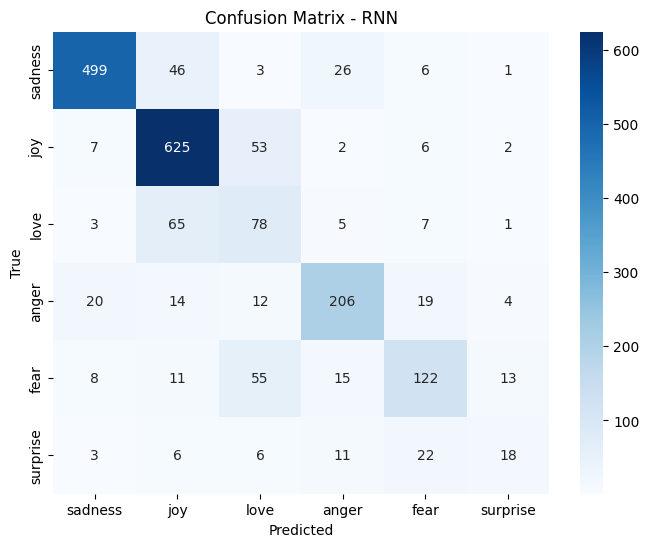

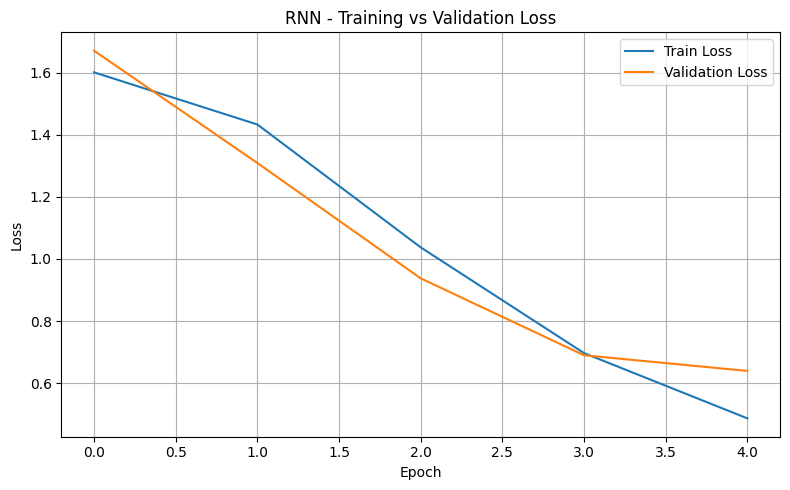

In [ ]:
# RNN bidirectional + random embedding + Keras tokenizer

# Load dataset
from datasets import load_dataset
dataset = load_dataset("dair-ai/emotion", "split")
dataset = dataset.map(clean_text)

MAX_LEN = 50

# Tokenize
tokenizer = Tokenizer()
tokenizer.fit_on_texts(dataset['train']['cleaned_text'])

def tokenize(example):
    seq = tokenizer.texts_to_sequences([example['cleaned_text']])
    padded = pad_sequences(seq, maxlen=MAX_LEN, padding='post')
    return {'input_ids': padded[0]}

dataset = dataset.map(tokenize)

# Import Dataset and DataLoader from PyTorch
from torch.utils.data import DataLoader, Dataset
import torch

# Define a custom dataset wrapper for the tokenized emotion dataset
class EmotionDataset(Dataset):
    def __init__(self, dataset_split):
        self.input_ids = dataset_split['input_ids']
        self.labels = dataset_split['label']

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            'input_ids': torch.tensor(self.input_ids[idx])
        }, torch.tensor(self.labels[idx])

class EmotionClassifier(torch.nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, output_dim, pad_idx):
        super().__init__()
        self.embedding = torch.nn.Embedding(vocab_size, embed_dim, padding_idx=pad_idx) # random
        self.rnn = torch.nn.RNN(embed_dim, hidden_dim, num_layers=2, batch_first=True, bidirectional=True, dropout=0.3)
        self.fc = torch.nn.Linear(hidden_dim * 2, output_dim) # add both directions

    def forward(self, input_ids):
        embedded = self.embedding(input_ids)                # [batch, seq_len, embed_dim]
        output, hidden = self.rnn(embedded)                 # hidden: [num_layers * 2, batch, hidden_dim]
        hidden_cat = torch.cat((hidden[-2], hidden[-1]), dim=1)  # Concatenate forward and backward last layers
        output = self.fc(hidden_cat)                        # Final output
        return output

# Define model hyperparameters
vocab_size = len(tokenizer.word_index) + 1        # Size of the tokenizer's vocabulary
embed_dim = 128                          # Word embedding vector size
hidden_dim = 256                         # GRU hidden state size
output_dim = 6                           # Number of emotion classes

model = EmotionClassifier(vocab_size, embed_dim, hidden_dim, output_dim, pad_idx=0)

# Create datasets for training, validation, and testing
train_dataset = EmotionDataset(dataset['train'])
val_dataset = EmotionDataset(dataset['validation'])
test_dataset = EmotionDataset(dataset['test'])

# Define DataLoaders for batching
test_loader = DataLoader(test_dataset, batch_size=32)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

# Loss and optimizer
criterion = torch.nn.CrossEntropyLoss()              # Standard classification loss
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Run training
train_losses, val_losses = train_model(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    num_epochs=5,
    model_name="RNN"
)

torch.save(model.state_dict(), "rnn.pth")
count_parameters(model)
evaluate_and_plot_metrics("RNN", model, test_loader, dataset['train'].features['label'].names)
plot_loss_curves("RNN", train_losses, val_losses)

## LSTM

### LSTM + random + Keras


LSTM + Random + Keras | Epoch 1 | Train Loss: 1.0360 | Val Loss: 0.4710
LSTM + Random + Keras | Epoch 2 | Train Loss: 0.2984 | Val Loss: 0.2776
LSTM + Random + Keras | Epoch 3 | Train Loss: 0.1446 | Val Loss: 0.2569
LSTM + Random + Keras | Epoch 4 | Train Loss: 0.0965 | Val Loss: 0.2952
LSTM + Random + Keras | Epoch 5 | Train Loss: 0.0633 | Val Loss: 0.3080

Total Trainable Parameters: 4,096,262


Classification Report for LSTM + Random + Keras:

              precision    recall  f1-score   support

     sadness     0.9242    0.9449    0.9345       581
         joy     0.9303    0.9022    0.9160       695
        love     0.8026    0.7673    0.7846       159
       anger     0.9091    0.9091    0.9091       275
        fear     0.8726    0.8259    0.8486       224
    surprise     0.6452    0.9091    0.7547        66

    accuracy                         0.8965      2000
   macro avg     0.8473    0.8764    0.8579      2000
weighted avg     0.8996    0.8965    0.8971      2000

Accura

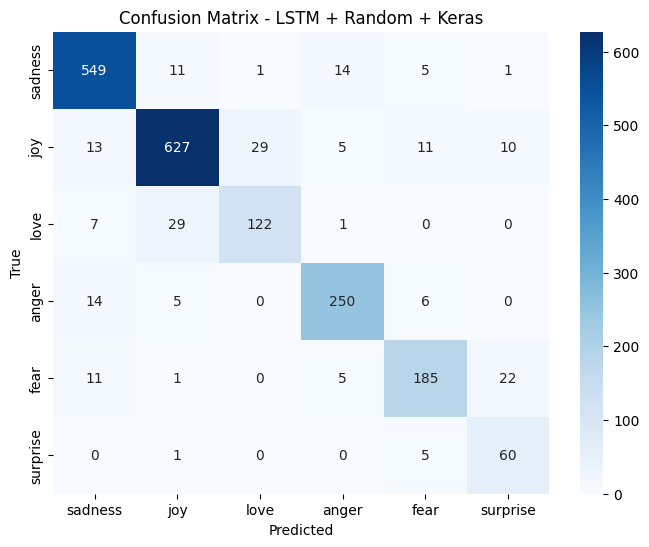

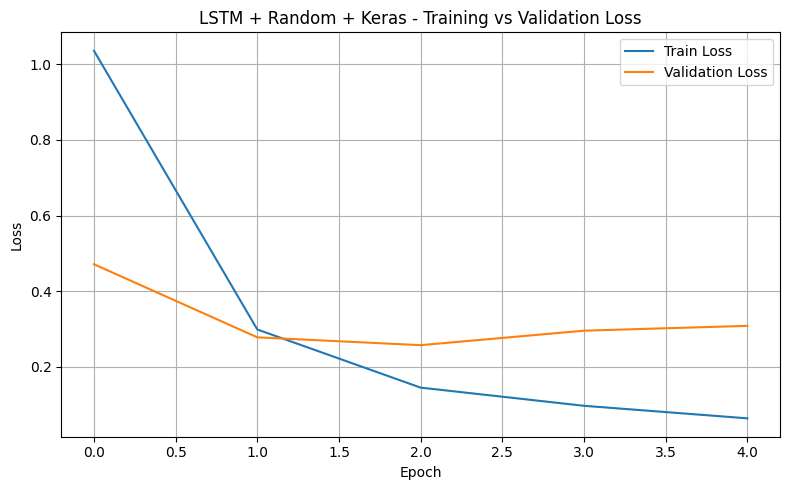

In [ ]:
# LSTM + random + Keras

# Load dataset
from datasets import load_dataset
dataset = load_dataset("dair-ai/emotion", "split")
dataset = dataset.map(clean_text)

# Tokenize
tokenizer = Tokenizer()
tokenizer.fit_on_texts(dataset['train']['cleaned_text'])

MAX_LEN = 50

def tokenize(example):
    seq = tokenizer.texts_to_sequences([example['cleaned_text']])
    padded = pad_sequences(seq, maxlen=MAX_LEN, padding='post')
    return {'input_ids': padded[0]}

dataset = dataset.map(tokenize)

# Import Dataset and DataLoader from PyTorch
from torch.utils.data import DataLoader, Dataset
import torch

# Define a custom dataset wrapper for the tokenized emotion dataset
# updated for LSTM
class EmotionDataset(Dataset):
    def __init__(self, dataset_split):
        self.input_ids = dataset_split['input_ids']
        self.labels = dataset_split['label']

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            'input_ids': torch.tensor(self.input_ids[idx])
        }, torch.tensor(self.labels[idx])


class EmotionClassifier(torch.nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, output_dim, pad_idx):
        super().__init__()
        self.embedding = torch.nn.Embedding(vocab_size, embed_dim, padding_idx=pad_idx) # random
        self.rnn = torch.nn.LSTM(embed_dim, hidden_dim, num_layers=2, batch_first=True, bidirectional=True, dropout=0.3)
        self.fc = torch.nn.Linear(hidden_dim * 2, output_dim) # add both directions

    def forward(self, input_ids):
        embedded = self.embedding(input_ids)                       # [batch, seq_len, embed_dim]
        _, (hidden, _) = self.rnn(embedded)                        # hidden: [2, batch, hidden_dim]
        # Concatenate forward and backward final hidden states
        hidden_cat = torch.cat((hidden[-2], hidden[-1]), dim=1)    # [batch, hidden_dim * 2]
        output = self.fc(hidden_cat)                               # [batch, num_classes]
        return output

# Create datasets for training, validation, and testing
train_dataset = EmotionDataset(dataset['train'])
val_dataset = EmotionDataset(dataset['validation'])
test_dataset = EmotionDataset(dataset['test'])

# Define model hyperparameters
vocab_size = len(tokenizer.word_index) + 1        # Size of the tokenizer's vocabulary
embed_dim = 128                          # Word embedding vector size
hidden_dim = 256                         # hidden state size
output_dim = 6                           # Number of emotion classes


model = EmotionClassifier(vocab_size, embed_dim, hidden_dim, output_dim, pad_idx=0)

# Define DataLoaders for batching
test_loader = DataLoader(test_dataset, batch_size=32)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

# Loss and optimizer
criterion = torch.nn.CrossEntropyLoss()              # Standard classification loss
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Run training
train_losses, val_losses = train_model(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    num_epochs=5,
    model_name="LSTM + Random + Keras"
)

# Save LSTM model
torch.save(model.state_dict(), "lstm_model_random_keras.pth")

# Print total trainable parameters
count_parameters(model)

# Evaluate model
evaluate_and_plot_metrics("LSTM + Random + Keras", model, test_loader, dataset['train'].features['label'].names)

# Plot training vs validation loss
plot_loss_curves("LSTM + Random + Keras", train_losses, val_losses)


### LSTM + GloVe + Keras

LSTM + GloVe + Keras | Epoch 1 | Train Loss: 0.3613 | Val Loss: 0.2134
LSTM + GloVe + Keras | Epoch 2 | Train Loss: 0.0729 | Val Loss: 0.2098
LSTM + GloVe + Keras | Epoch 3 | Train Loss: 0.0481 | Val Loss: 0.2113
LSTM + GloVe + Keras | Epoch 4 | Train Loss: 0.0461 | Val Loss: 0.2557
LSTM + GloVe + Keras | Epoch 5 | Train Loss: 0.0321 | Val Loss: 0.2565

Total Trainable Parameters: 6,767,422


Classification Report for LSTM + GloVe + Keras:

              precision    recall  f1-score   support

     sadness     0.9754    0.9535    0.9643       581
         joy     0.9705    0.8993    0.9335       695
        love     0.7000    0.9245    0.7967       159
       anger     0.8949    0.9600    0.9263       275
        fear     0.9381    0.8125    0.8708       224
    surprise     0.6742    0.9091    0.7742        66

    accuracy                         0.9160      2000
   macro avg     0.8588    0.9098    0.8777      2000
weighted avg     0.9266    0.9160    0.9183      2000

Accuracy: 0.

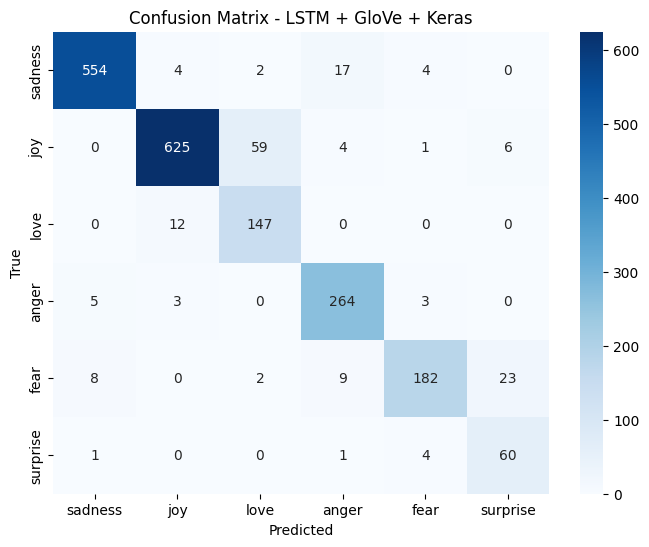

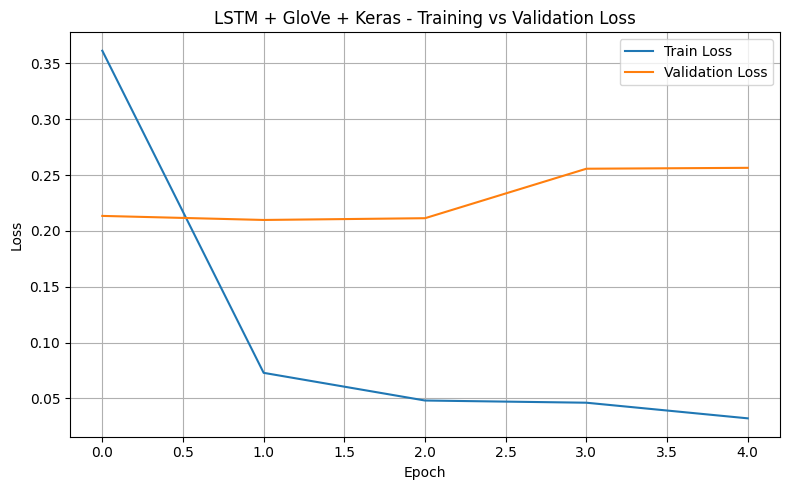

In [ ]:
# LSTM + GloVe + Keras

# Load dataset
from datasets import load_dataset
dataset = load_dataset("dair-ai/emotion", "split")
dataset = dataset.map(clean_text)

# Tokenize
tokenizer = Tokenizer()
tokenizer.fit_on_texts(dataset['train']['cleaned_text'])

MAX_LEN = 50

def tokenize(example):
    seq = tokenizer.texts_to_sequences([example['cleaned_text']])
    padded = pad_sequences(seq, maxlen=MAX_LEN, padding='post')
    return {'input_ids': padded[0]}

dataset = dataset.map(tokenize)

# Import Dataset and DataLoader from PyTorch
from torch.utils.data import DataLoader, Dataset
import torch

# Define a custom dataset wrapper for the tokenized emotion dataset
# updated for LSTM
class EmotionDataset(Dataset):
    def __init__(self, dataset_split):
        self.input_ids = dataset_split['input_ids']
        self.labels = dataset_split['label']

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            'input_ids': torch.tensor(self.input_ids[idx])
        }, torch.tensor(self.labels[idx])


class EmotionClassifier(torch.nn.Module):
    def __init__(self, embedding_layer, hidden_dim, output_dim):
        super().__init__()
        self.embedding = embedding_layer  # From GloVe
        self.rnn = torch.nn.LSTM(embedding_layer.embedding_dim, hidden_dim,
                                 num_layers=2, batch_first=True,
                                 bidirectional=True, dropout=0.3)
        self.fc = torch.nn.Linear(hidden_dim * 2, output_dim)

    def forward(self, input_ids):
        embedded = self.embedding(input_ids)
        _, (hidden, _) = self.rnn(embedded)
        hidden_cat = torch.cat((hidden[-2], hidden[-1]), dim=1)
        return self.fc(hidden_cat)


# Create datasets for training, validation, and testing
train_dataset = EmotionDataset(dataset['train'])
val_dataset = EmotionDataset(dataset['validation'])
test_dataset = EmotionDataset(dataset['test'])

hidden_dim = 256                         # hidden state size
output_dim = 6                           # Number of emotion classes

model = EmotionClassifier(glove_embedding, hidden_dim, output_dim)

# Define DataLoaders for batching
test_loader = DataLoader(test_dataset, batch_size=32)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

# Loss and optimizer
criterion = torch.nn.CrossEntropyLoss()              # Standard classification loss
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Run training
train_losses, val_losses = train_model(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    num_epochs=5,
    model_name="LSTM + GloVe + Keras"
)

# Save LSTM model
torch.save(model.state_dict(), "lstm_model_GloVe_keras.pth")

# Print total trainable parameters
count_parameters(model)

# Evaluate model
evaluate_and_plot_metrics("LSTM + GloVe + Keras", model, test_loader, dataset['train'].features['label'].names)

# Plot training vs validation loss
plot_loss_curves("LSTM + GloVe + Keras", train_losses, val_losses)

## GRU

Map: 100%|██████████| 2000/2000 [00:00<00:00, 6514.53 examples/s]


GRU + GloVe + Keras | Epoch 1 | Train Loss: 0.6187 | Val Loss: 0.1624
GRU + GloVe + Keras | Epoch 2 | Train Loss: 0.0761 | Val Loss: 0.1650
GRU + GloVe + Keras | Epoch 3 | Train Loss: 0.0517 | Val Loss: 0.1680
GRU + GloVe + Keras | Epoch 4 | Train Loss: 0.0361 | Val Loss: 0.1758
GRU + GloVe + Keras | Epoch 5 | Train Loss: 0.0264 | Val Loss: 0.2206

Total Trainable Parameters: 4,474,686


Classification Report for GRU + GloVe + Keras:

              precision    recall  f1-score   support

     sadness     0.9590    0.9656    0.9623       581
         joy     0.9613    0.9295    0.9451       695
        love     0.8242    0.8553    0.8395       159
       anger     0.9605    0.8836    0.9205       275
        fear     0.8167    0.8750    0.8448       224
    surprise     0.6824    0.8788    0.7682        66

    accuracy                         0.9200      2000
   macro avg     0.8673    0.8980    0.8801      2000
weighted avg     0.9242    0.9200    0.9212      2000

Accuracy: 0.9200
M

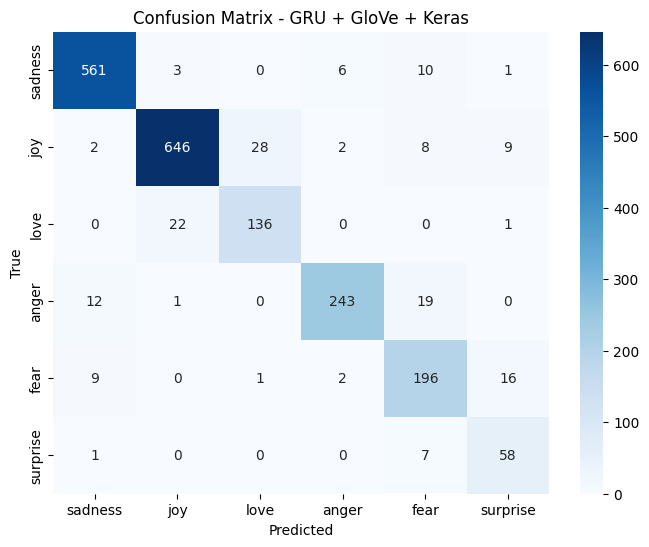

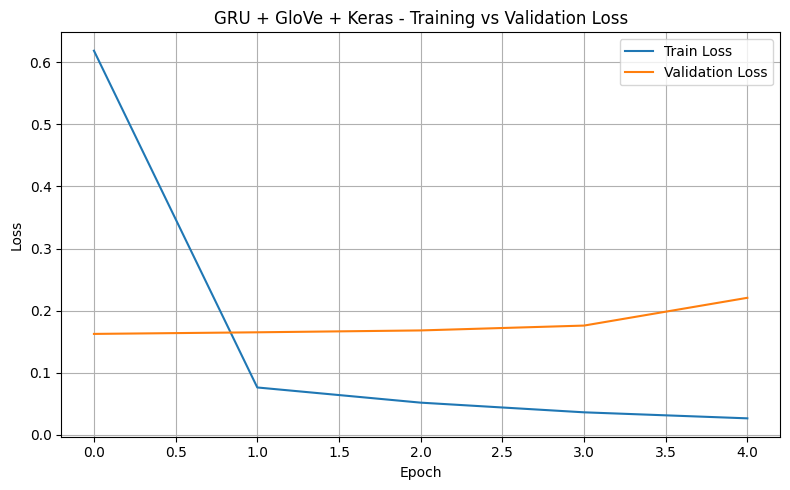

In [ ]:
# GRU + GloVe + Keras

# Load dataset
from datasets import load_dataset
dataset = load_dataset("dair-ai/emotion", "split")
dataset = dataset.map(clean_text)

# Tokenize
tokenizer = Tokenizer()
tokenizer.fit_on_texts(dataset['train']['cleaned_text'])

MAX_LEN = 50

def tokenize(example):
    seq = tokenizer.texts_to_sequences([example['cleaned_text']])
    padded = pad_sequences(seq, maxlen=MAX_LEN, padding='post')
    return {'input_ids': padded[0]}

dataset = dataset.map(tokenize)

# Import Dataset and DataLoader from PyTorch
from torch.utils.data import DataLoader, Dataset
import torch

class EmotionDataset(Dataset):
    def __init__(self, dataset_split):
        self.input_ids = dataset_split['input_ids']
        self.labels = dataset_split['label']

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            'input_ids': torch.tensor(self.input_ids[idx])
        }, torch.tensor(self.labels[idx])

class EmotionClassifier(torch.nn.Module):
    def __init__(self, embedding_layer, hidden_dim, output_dim):
        super().__init__()
        self.embedding = embedding_layer
        self.rnn = torch.nn.GRU(embedding_layer.embedding_dim, hidden_dim, batch_first=True)
        self.fc = torch.nn.Linear(hidden_dim, output_dim)

    def forward(self, input_ids):
        embedded = self.embedding(input_ids)
        _, hidden = self.rnn(embedded)
        output = self.fc(hidden.squeeze(0))
        return output

# Create datasets for training, validation, and testing
train_dataset = EmotionDataset(dataset['train'])
val_dataset = EmotionDataset(dataset['validation'])
test_dataset = EmotionDataset(dataset['test'])

# Define GRU model hyperparameters
hidden_dim = 256                         # GRU hidden state size
output_dim = 6                           # Number of emotion classes

# Instantiate the model: an RNN with GRU inside
model = EmotionClassifier(glove_embedding, hidden_dim, output_dim)

# Define DataLoaders for batching
test_loader = DataLoader(test_dataset, batch_size=32)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

# Loss and optimizer
criterion = torch.nn.CrossEntropyLoss()              # Standard classification loss
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Run training
train_losses, val_losses = train_model(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    num_epochs=5,
    model_name="GRU + GloVe + Keras"
)

# Save LSTM model
torch.save(model.state_dict(), "GRU_model_GloVe_keras.pth")

# Print total trainable parameters
count_parameters(model)

# Evaluate model
evaluate_and_plot_metrics("GRU + GloVe + Keras", model, test_loader, dataset['train'].features['label'].names)

# Plot training vs validation loss
plot_loss_curves("GRU + GloVe + Keras", train_losses, val_losses)

## DistilBERT

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1 | Train Loss: 0.4628 | Val Loss: 0.1689
Epoch 2 | Train Loss: 0.1428 | Val Loss: 0.1581
Epoch 3 | Train Loss: 0.1034 | Val Loss: 0.1535
Epoch 4 | Train Loss: 0.0882 | Val Loss: 0.1711
Epoch 5 | Train Loss: 0.0759 | Val Loss: 0.1522

Total Trainable Parameters: 66,958,086


DistilBERT Classification Report:
              precision    recall  f1-score   support

     sadness       0.97      0.97      0.97       581
         joy       0.97      0.92      0.94       695
        love       0.76      0.93      0.84       159
       anger       0.92      0.94      0.93       275
        fear       0.88      0.95      0.91       224
    surprise       0.97      0.56      0.71        66

    accuracy                           0.93      2000
   macro avg       0.91      0.88      0.88      2000
weighted avg       0.93      0.93      0.93      2000

Accuracy: 0.9300
Macro Avg Precision: 0.9112 | Recall: 0.8785 | F1: 0.8838


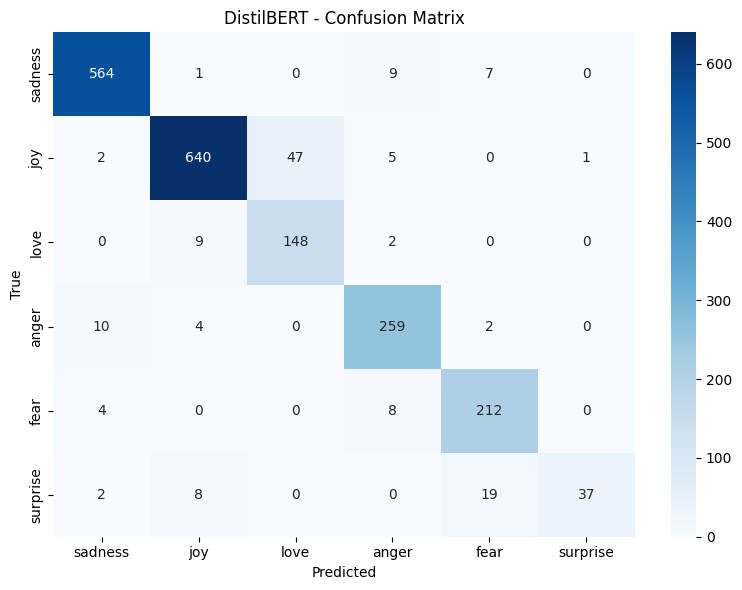

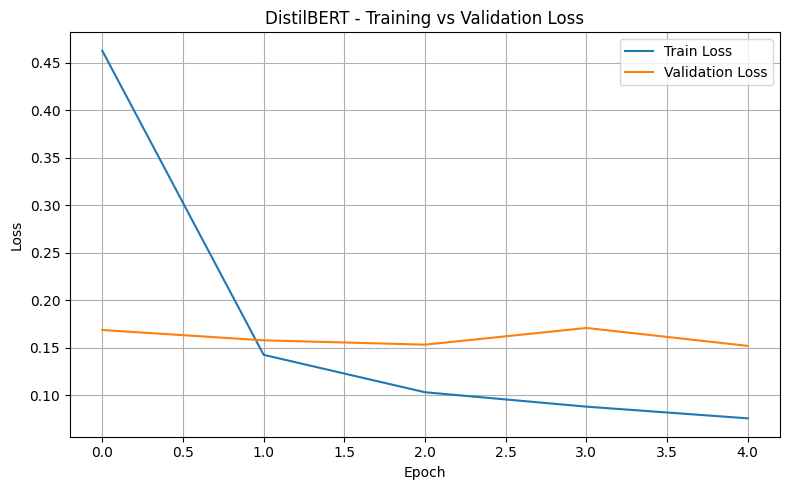

In [ ]:
# DistilBERT

import torch
from torch.utils.data import DataLoader, Dataset
from transformers import DistilBertForSequenceClassification, AutoTokenizer

# Load dataset
from datasets import load_dataset
dataset = load_dataset("dair-ai/emotion", "split")
dataset = dataset.map(clean_text)

# Tokenize using HuggingFace tokenizer
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
MAX_LEN = 128

def tokenize(example):
    return tokenizer(example['cleaned_text'], truncation=True, padding='max_length', max_length=MAX_LEN)

dataset = dataset.map(tokenize)

class EmotionDataset(Dataset):
    def __init__(self, dataset_split):
        self.input_ids = dataset_split['input_ids']
        self.attention_mask = dataset_split['attention_mask']
        self.labels = dataset_split['label']

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            'input_ids': torch.tensor(self.input_ids[idx]),
            'attention_mask': torch.tensor(self.attention_mask[idx])
        }, torch.tensor(self.labels[idx])

# Create datasets for training, validation, and testing
train_dataset = EmotionDataset(dataset['train'])
val_dataset = EmotionDataset(dataset['validation'])
test_dataset = EmotionDataset(dataset['test'])

# Load model DistilBert
from transformers import DistilBertForSequenceClassification

num_labels = len(dataset['train'].features['label'].names)
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=num_labels)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)
test_loader = DataLoader(test_dataset, batch_size=32)

from torch.optim import AdamW
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

criterion = torch.nn.CrossEntropyLoss()
optimizer = AdamW(model.parameters(), lr=2e-5)

train_losses, val_losses = train_transformer_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    criterion=criterion,
    num_epochs=5,
    device=device
)

# Save model
model.save_pretrained("distilbert_emotion_model")

# Save tokenizer
tokenizer.save_pretrained("distilbert_emotion_model")

# Print total trainable parameters
count_parameters(model)

def evaluate_and_plot_metrics_transformer(name, model, dataloader, class_names, device=None):
    import torch
    from sklearn.metrics import classification_report, confusion_matrix
    import matplotlib.pyplot as plt
    import seaborn as sns

    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model.eval()
    model.to(device)

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in dataloader:
            inputs, labels = batch
            input_ids = inputs['input_ids'].to(device)
            attention_mask = inputs['attention_mask'].to(device)
            labels = labels.to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            preds = torch.argmax(logits, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Print classification report
    print(f"\n{name} Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names))

    # Get macro-averaged metrics
    report = classification_report(all_labels, all_preds, target_names=class_names, digits=4, output_dict=True)
    macro_avg = report['macro avg']
    accuracy = report['accuracy']
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Macro Avg Precision: {macro_avg['precision']:.4f} | Recall: {macro_avg['recall']:.4f} | F1: {macro_avg['f1-score']:.4f}")

    # Plot confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names,
                yticklabels=class_names)
    plt.title(f'{name} - Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.tight_layout()
    plt.show()

evaluate_and_plot_metrics_transformer("DistilBERT", model, test_loader, dataset['train'].features['label'].names)
plot_loss_curves("DistilBERT", train_losses, val_losses)

## ELECTRA

Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-small-discriminator and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `ElectraSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Epoch 1/10 | Train Loss: 1.1841 | Val Loss: 0.6159
Epoch 2/10 | Train Loss: 0.4590 | Val Loss: 0.2750
Epoch 3/10 | Train Loss: 0.2393 | Val Loss: 0.1830
Epoch 4/10 | Train Loss: 0.1703 | Val Loss: 0.1676
Epoch 5/10 | Train Loss: 0.1399 | Val Loss: 0.1497
Epoch 6/10 | Train Loss: 0.1243 | Val Loss: 0.1444
Epoch 7/10 | Train Loss: 0.1084 | Val Loss: 0.1434
Epoch 8/10 | Train Loss: 0.1011 | Val Loss: 0.1478
Epoch 9/10 | Train Loss: 0.0928 | Val Loss: 0.1276
Epoch 10/10 | Train Loss: 0.0907 | Val Loss: 0.1487

ELECTRA Classification Report:
              precision    recall  f1-score   support

     sadness       0.96      0.98      0.97       581
         joy       0.92      0.99      0.95       695
        love       0.98      0.70      0.82       159
       anger       0.97      0.91      0.94       275
        fear       0.90      0.92      0.91       224
    surprise       0.88      0.70      0.78        66

    accuracy                           0.94      2000
   macro avg       0.93

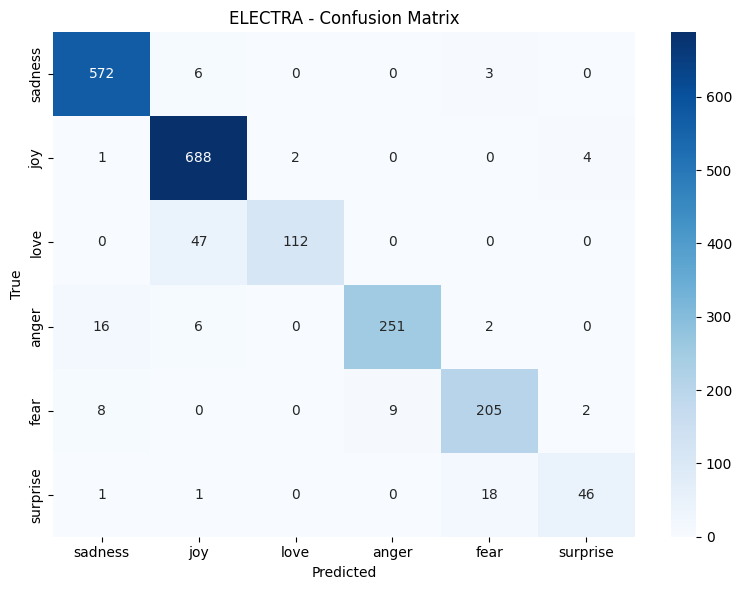

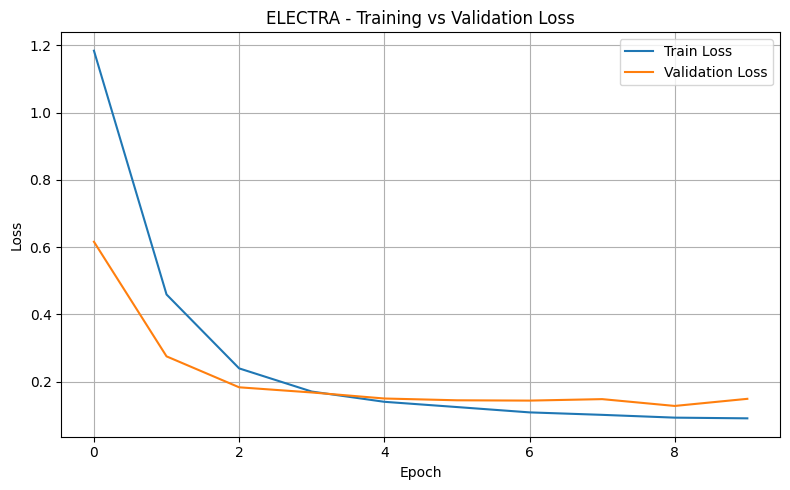

In [ ]:
from transformers import ElectraTokenizer, ElectraForSequenceClassification
import torch
from torch.utils.data import DataLoader, Dataset
from transformers import DistilBertForSequenceClassification, AutoTokenizer

# Load dataset
from datasets import load_dataset
dataset = load_dataset("dair-ai/emotion", "split")
dataset = dataset.map(clean_text)

# Get number of unique labels from the dataset
num_labels = len(dataset['train'].features['label'].names)

# Load ELECTRA tokenizer and model
electra_tokenizer = ElectraTokenizer.from_pretrained("google/electra-small-discriminator")
electra_model = ElectraForSequenceClassification.from_pretrained("google/electra-small-discriminator", num_labels=num_labels)

def electra_tokenize(example):
    return electra_tokenizer(example['cleaned_text'], truncation=True, padding='max_length', max_length=128)

# Apply ELECTRA tokenizer
electra_dataset = dataset.map(electra_tokenize)

class ElectraEmotionDataset(Dataset):
    def __init__(self, dataset_split):
        self.input_ids = dataset_split['input_ids']
        self.attention_mask = dataset_split['attention_mask']
        self.labels = dataset_split['label']

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            'input_ids': torch.tensor(self.input_ids[idx]),
            'attention_mask': torch.tensor(self.attention_mask[idx])
        }, torch.tensor(self.labels[idx])

electra_train_dataset = ElectraEmotionDataset(electra_dataset['train'])
electra_val_dataset = ElectraEmotionDataset(electra_dataset['validation'])
electra_test_dataset = ElectraEmotionDataset(electra_dataset['test'])

electra_train_loader = DataLoader(electra_train_dataset, batch_size=16, shuffle=True)
electra_val_loader = DataLoader(electra_val_dataset, batch_size=16)
electra_test_loader = DataLoader(electra_test_dataset, batch_size=32)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


from torch.optim import AdamW
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

electra_model.to(device)
electra_optimizer = AdamW(electra_model.parameters(), lr=2e-5)
electra_criterion = torch.nn.CrossEntropyLoss()

def train_electra_model(model, train_loader, val_loader, optimizer, criterion, num_epochs=5, device=None):
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model.to(device)
    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        model.train()
        total_train_loss = 0

        for batch in train_loader:
            inputs, labels = batch
            input_ids = inputs['input_ids'].to(device)
            attention_mask = inputs['attention_mask'].to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            loss = criterion(outputs.logits, labels)
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()

        avg_train_loss = total_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Validation
        model.eval()
        total_val_loss = 0
        with torch.no_grad():
            for batch in val_loader:
                inputs, labels = batch
                input_ids = inputs['input_ids'].to(device)
                attention_mask = inputs['attention_mask'].to(device)
                labels = labels.to(device)

                outputs = model(input_ids=input_ids, attention_mask=attention_mask)
                loss = criterion(outputs.logits, labels)
                total_val_loss += loss.item()

        avg_val_loss = total_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")

    return train_losses, val_losses

electra_train_losses, electra_val_losses = train_electra_model(
    model=electra_model,
    train_loader=electra_train_loader,
    val_loader=electra_val_loader,
    optimizer=electra_optimizer,
    criterion=electra_criterion,
    num_epochs=10,
    device=device
)


electra_model.save_pretrained("electra_emotion_model")
electra_tokenizer.save_pretrained("electra_emotion_model")

evaluate_and_plot_metrics_transformer("ELECTRA", electra_model, electra_test_loader, dataset['train'].features['label'].names)
plot_loss_curves("ELECTRA", electra_train_losses, electra_val_losses)


In [ ]:
count_parameters(electra_model) # For ELECTRA


Total Trainable Parameters: 13,550,342



In [ ]:
# WORKING
# Below is irrelevant

Results (3 marks): Results are clearly shown, discussed, evaluated using appropriate metrics. Good
use of graphs or other visualizations, where possible. Comparison with previous methods/State-of-theart, where appropriate.

# Discussion

(2 marks): Discuss the results and analysis, provide some insight about system
performance, including strengths, weaknesses, limitations and possible future work.

In [ ]:
custom_text = "we will cross well over 1 million GPUs brought online by the end of this year! very proud of the team but now they better get to work figuring out how to 100x that lol"

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import torch

MAX_LEN = 128

# Import Dataset and DataLoader from PyTorch
from torch.utils.data import DataLoader, Dataset
import torch

class EmotionDataset(Dataset):
    def __init__(self, dataset_split):
        self.input_ids = dataset_split['input_ids']
        self.labels = dataset_split['label']

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            'input_ids': torch.tensor(self.input_ids[idx])
        }, torch.tensor(self.labels[idx])

class EmotionClassifier(torch.nn.Module):
    def __init__(self, embedding_layer, hidden_dim, output_dim):
        super().__init__()
        self.embedding = embedding_layer
        self.rnn = torch.nn.GRU(embedding_layer.embedding_dim, hidden_dim, batch_first=True)
        self.fc = torch.nn.Linear(hidden_dim, output_dim)

    def forward(self, input_ids):
        embedded = self.embedding(input_ids)
        _, hidden = self.rnn(embedded)
        output = self.fc(hidden.squeeze(0))
        return output
# Load tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(dataset['train']['cleaned_text'])  # must use same training data
sequence = tokenizer.texts_to_sequences([custom_text])
padded = pad_sequences(sequence, maxlen=MAX_LEN, padding='post')
input_tensor = torch.tensor(padded, dtype=torch.long)

# Define same architecture
model = EmotionClassifier(glove_embedding, hidden_dim=256, output_dim=6)
model.load_state_dict(torch.load("GRU_model_GloVe_keras.pth"))
model.eval()

with torch.no_grad():
    output = model(input_tensor)
    probs = torch.softmax(output, dim=1).squeeze()
    pred_label = torch.argmax(probs).item()

# Get label name
label_names = dataset['train'].features['label'].names
print(f"Prediction: {label_names[pred_label]}")
print("All Scores:")
for i, prob in enumerate(probs):
    print(f"{label_names[i]}: {prob:.4f}")

Prediction: joy
All Scores:
sadness: 0.0005
joy: 0.9047
love: 0.0391
anger: 0.0338
fear: 0.0025
surprise: 0.0193


In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

# Load from local folder
model = AutoModelForSequenceClassification.from_pretrained("./distilbert_emotion_model")
tokenizer = AutoTokenizer.from_pretrained("./distilbert_emotion_model")
model.eval()

inputs = tokenizer(custom_text, return_tensors="pt", truncation=True, padding=True)

with torch.no_grad():
    outputs = model(**inputs)
    probs = torch.softmax(outputs.logits, dim=1).squeeze()
    pred_label = torch.argmax(probs).item()

# Get label names
label_names = dataset['train'].features['label'].names
print(f"Prediction: {label_names[pred_label]}")
print("All Scores:")
for i, prob in enumerate(probs):
    print(f"{label_names[i]}: {prob:.4f}")


SafetensorError: Error while deserializing header: MetadataIncompleteBuffer

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

# Load from local folder
model = AutoModelForSequenceClassification.from_pretrained("./electra_emotion_model")
tokenizer = AutoTokenizer.from_pretrained("./electra_emotion_model")
model.eval()

inputs = tokenizer(custom_text, return_tensors="pt", truncation=True, padding=True)

with torch.no_grad():
    outputs = model(**inputs)
    probs = torch.softmax(outputs.logits, dim=1).squeeze()
    pred_label = torch.argmax(probs).item()

# Get label names
label_names = dataset['train'].features['label'].names
print(f"Prediction: {label_names[pred_label]}")
print("All Scores:")
for i, prob in enumerate(probs):
    print(f"{label_names[i]}: {prob:.4f}")

Prediction: joy
All Scores:
sadness: 0.0001
joy: 0.9995
love: 0.0003
anger: 0.0000
fear: 0.0000
surprise: 0.0001


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `ElectraSelfAttention.forward`.
  return forward_call(*args, **kwargs)
